In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Import Libraries

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_curve, roc_curve
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score


Data Read and Pre-processing

In [11]:
dataset=pd.read_csv('/content/drive/MyDrive/475 Project/diabetes.csv')
dataset.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [12]:
dataset.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [13]:
#checking if any null value in whole dataset
null_values = dataset.isnull().sum()
print(null_values)

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


In [14]:
#cheking zeros in dataset
glu = (dataset['Glucose']==0).sum()
bp = (dataset['BloodPressure']==0).sum()
bmi = (dataset['BMI']==0).sum() 
print(glu)
print(bp)
print(bmi)

5
35
11


In [15]:
#glucose, blood_pressure, BMI can not be zero. 
#filling zero values with median
dataset.Glucose.replace(0,dataset.Glucose.mean(), inplace=True)
dataset.BloodPressure.replace(0,dataset.BloodPressure.mean(), inplace=True)
dataset.BMI.replace(0,dataset.BMI.mean(), inplace=True)
dataset.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35,0,33.6,0.627,50,1
1,1,85.0,66.0,29,0,26.6,0.351,31,0
2,8,183.0,64.0,0,0,23.3,0.672,32,1
3,1,89.0,66.0,23,94,28.1,0.167,21,0
4,0,137.0,40.0,35,168,43.1,2.288,33,1


Data visualization

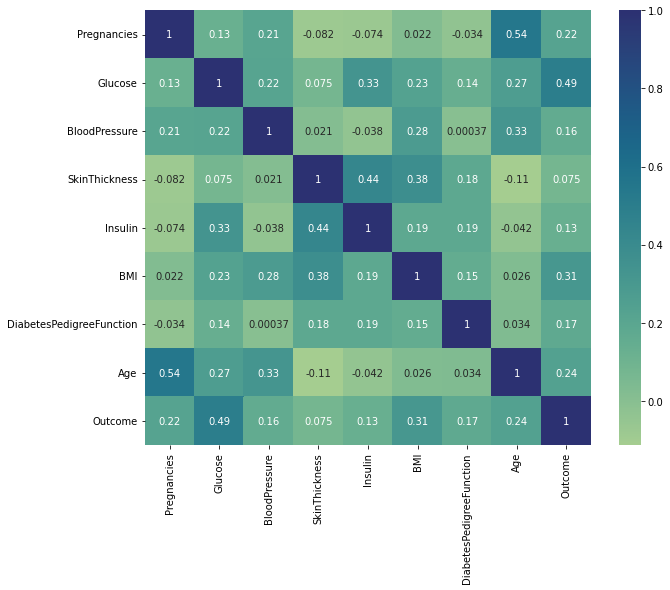

In [16]:
plt.figure(figsize=(10,8))
sns.heatmap(dataset.corr(), annot=True, cmap="crest")
plt.show()

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


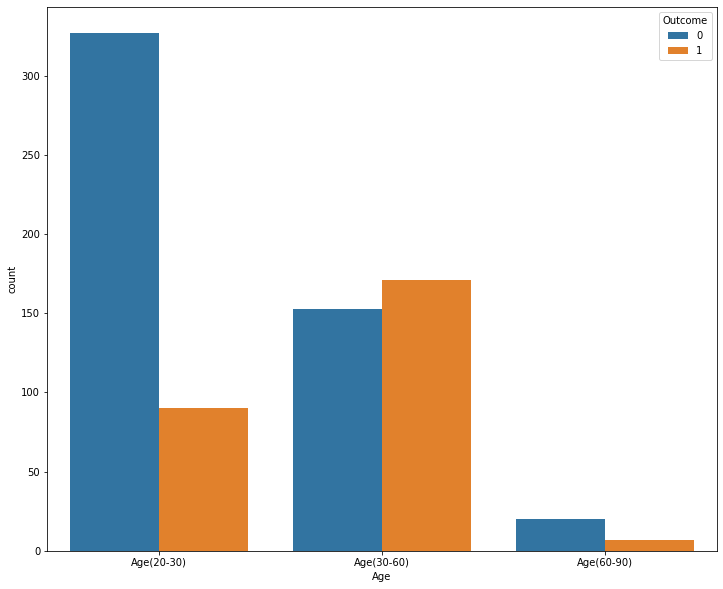

In [17]:
age_bins=pd.cut(dataset["Age"],bins=[20,30,60,90],labels=["Age(20-30)","Age(30-60)","Age(60-90)"])
plt.figure(figsize=(12,10))
sns.countplot(age_bins,hue=dataset["Outcome"])

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


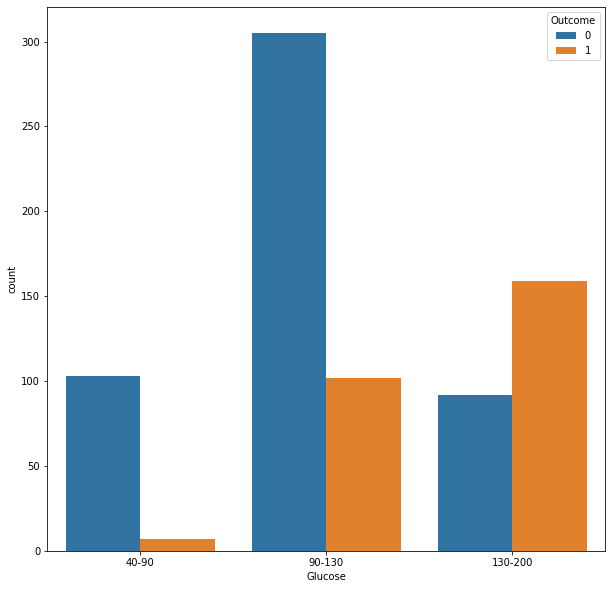

In [18]:
glucose_bins=pd.cut(dataset["Glucose"],bins=[40,90,130,200],labels=["40-90","90-130","130-200"])
plt.figure(figsize=(10,10))
sns.countplot(glucose_bins,hue=dataset["Outcome"])

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


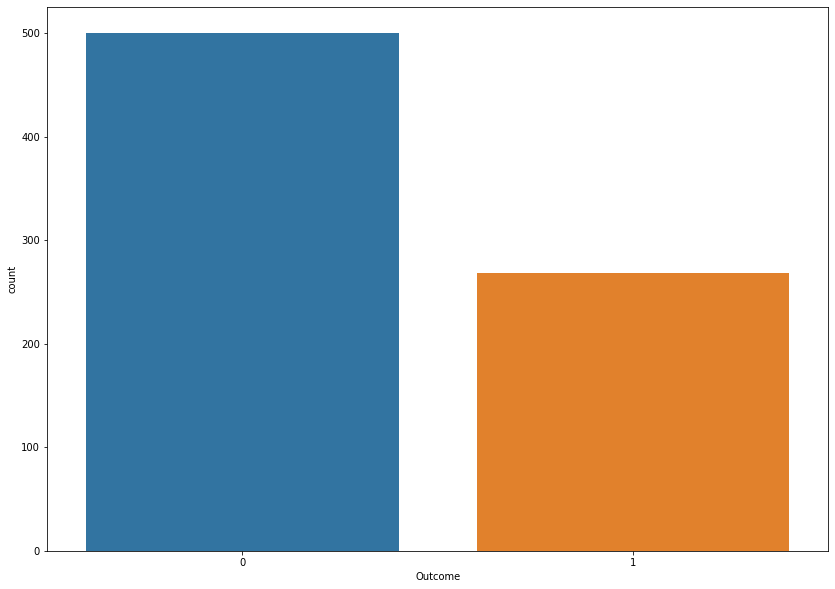

In [19]:
plt.figure(figsize=(14,10))
sns.countplot("Outcome",data=dataset)

Train test split


In [22]:
features=dataset.drop(['Outcome','DiabetesPedigreeFunction','SkinThickness'],axis =1)
labels=dataset.iloc[:,8].values

In [23]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,Y_test=train_test_split(features,labels,test_size=0.2,random_state=0)
print(X_train)

     Pregnancies  Glucose  BloodPressure  Insulin        BMI  Age
603            7    150.0      78.000000      126  35.200000   54
118            4     97.0      60.000000        0  28.200000   22
247            0    165.0      90.000000      680  52.300000   23
157            1    109.0      56.000000      135  25.200000   23
468            8    120.0      69.105469        0  30.000000   38
..           ...      ...            ...      ...        ...  ...
763           10    101.0      76.000000      180  32.900000   63
192            7    159.0      66.000000        0  30.400000   36
629            4     94.0      65.000000        0  24.700000   21
559           11     85.0      74.000000        0  30.100000   35
684            5    136.0      82.000000        0  31.992578   69

[614 rows x 6 columns]


Train with XGBCClassifier

In [24]:
# pipeline: scaling, dimensionality reduction, and classification.
from xgboost import XGBClassifier
steps = [('scaler', StandardScaler()),    
         ('pca', PCA(n_components=2)),   
         ('clf', XGBClassifier())]
  
pipe_lr = Pipeline(steps)

pipe_lr.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=2)),
                ('clf', XGBClassifier())])

In [25]:
y_pred=pipe_lr.predict(X_test)
y_score = pipe_lr.predict_proba(X_test)  #predict_proba method on the pipeline object "pipe_lr"

In [26]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(Y_test,y_pred)
print(cm)

[[91 16]
 [14 33]]


In [27]:
from sklearn.metrics import f1_score  
F1=f1_score(Y_test,y_pred,average='weighted') 
print("f1_score is =" + str(F1))

f1_score is =0.8063051335456997


In [28]:
def accuracy(confusion_matrix): 
    diagonal_sum = confusion_matrix.trace()
    sum_of_all_elements = confusion_matrix.sum()
    return diagonal_sum / sum_of_all_elements
    
result = accuracy(cm)

In [29]:
print("Accuracy of Xgboost classifier is =" + str(result) )

Accuracy of Xgboost classifier is =0.8051948051948052


In [30]:
from sklearn.metrics import classification_report
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.85      0.86       107
           1       0.67      0.70      0.69        47

    accuracy                           0.81       154
   macro avg       0.77      0.78      0.77       154
weighted avg       0.81      0.81      0.81       154



In [31]:
print(accuracy_score(Y_test,y_pred))

0.8051948051948052


Train with SVM

In [32]:
from sklearn.svm import SVC
steps = [('scaler', StandardScaler()),
         ('pca', PCA(n_components=2)),
         ('clf', SVC(kernel='linear',C=200))] 
pipe_lr = Pipeline(steps)

pipe_lr.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=2)),
                ('clf', SVC(C=200, kernel='linear'))])

In [33]:
y_pred=pipe_lr.predict(X_test)

In [34]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(Y_test,y_pred)
print(cm)

[[96 11]
 [22 25]]


In [35]:
from sklearn.metrics import f1_score
F1=f1_score(Y_test,y_pred,average='weighted')
print("f1_score is =" + str(F1))

f1_score is =0.7767527251864601


In [36]:
print(accuracy_score(Y_test,y_pred))

0.7857142857142857


In [37]:
from sklearn.metrics import classification_report
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.90      0.85       107
           1       0.69      0.53      0.60        47

    accuracy                           0.79       154
   macro avg       0.75      0.71      0.73       154
weighted avg       0.78      0.79      0.78       154



Train with logistic Regression

In [38]:
from sklearn.linear_model import LogisticRegression
steps = [('scaler', StandardScaler()),
         ('pca', PCA(n_components=2)),
         ('clf', LogisticRegression(C=0.05))]
  
pipe_lr = Pipeline(steps)

pipe_lr.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=2)),
                ('clf', LogisticRegression(C=0.05))])

In [39]:
y_pred=pipe_lr.predict(X_test)

In [40]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(Y_test,y_pred)
print(cm)

[[96 11]
 [22 25]]


In [41]:
from sklearn.metrics import f1_score
F1=f1_score(Y_test,y_pred,average='weighted')
print("f1_score is =" + str(F1))

f1_score is =0.7767527251864601


In [42]:
print(accuracy_score(Y_test,y_pred))

0.7857142857142857


In [43]:
from sklearn.metrics import classification_report
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.90      0.85       107
           1       0.69      0.53      0.60        47

    accuracy                           0.79       154
   macro avg       0.75      0.71      0.73       154
weighted avg       0.78      0.79      0.78       154



Train with random forest

In [44]:
from sklearn.ensemble import RandomForestClassifier
steps = [('scaler', StandardScaler()),
         ('pca', PCA(n_components=2)),
         ('clf',RandomForestClassifier(n_estimators = 100))]
pipe_lr = Pipeline(steps)

pipe_lr.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=2)),
                ('clf', RandomForestClassifier())])

In [45]:
y_pred=pipe_lr.predict(X_test)

In [46]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(Y_test,y_pred)
print(cm)

[[86 21]
 [17 30]]


In [47]:
from sklearn.metrics import f1_score
F1=f1_score(Y_test,y_pred,average='weighted')
print("f1_score is =" + str(F1))

f1_score is =0.7559325028712784


In [48]:
print(accuracy_score(Y_test,y_pred))

0.7532467532467533


In [49]:
from sklearn.metrics import classification_report
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.80      0.82       107
           1       0.59      0.64      0.61        47

    accuracy                           0.75       154
   macro avg       0.71      0.72      0.72       154
weighted avg       0.76      0.75      0.76       154



Summary of the 4 model performance

Text(0, 0.5, 'Evaluation Metrics')

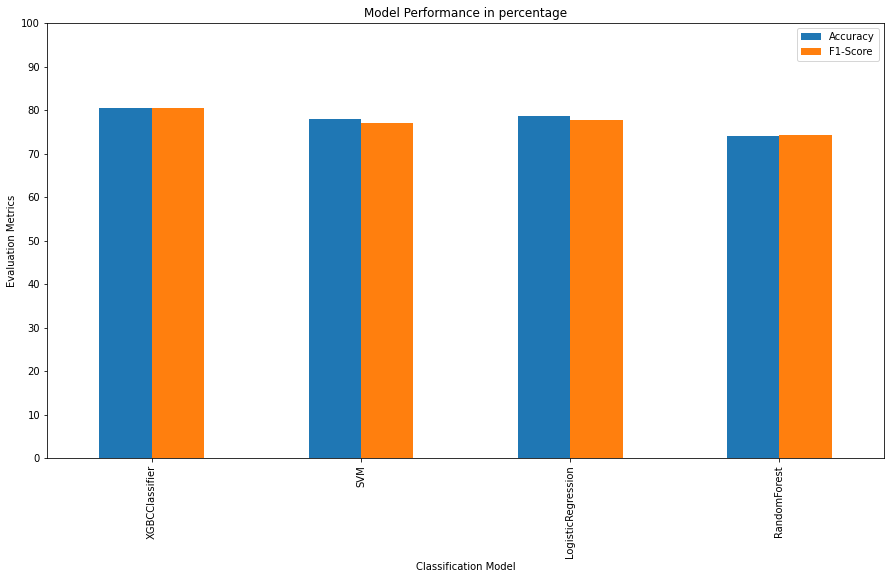

In [50]:
plotdata = pd.DataFrame({
    "Accuracy":[0.8051*100, 0.7792*100, 0.7857*100, 0.7402*100],
    "F1-Score":[0.8039*100,0.7710*100,0.7767*100,0.7417*100],},

    index=['XGBCClassifier', 'SVM', 'LogisticRegression', 'RandomForest'])

plotdata.plot(kind="bar",figsize=(15, 8))
plt.yticks(range(0, 101, 10))
plt.title("Model Performance in percentage")
plt.xlabel("Classification Model")
plt.ylabel("Evaluation Metrics")

A testcase

In [51]:
a=np.array([[6,	148,72,	0,	33.6,	50]])
pipe_lr.predict(a)

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


array([1])